In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import warnings
import pandas as pd

nPts = 100     ###No. of vortices in the camber vortex sheet
nSrs = 10      ###No. of Fourier Coefficients to calculate
warnings.filterwarnings("ignore", category=RuntimeWarning)  ###To ignore warning of the Infinity output of known values

###Literature Data.xlsx contains Manually extracted data of Abbott and Von-Doenhoff-Theory of Wing Sections and XFLR5 data
### for NACA 0012,NACA 2412,NACA 4412 with an Angle of Attack -8 to 8 in 2 degree step
data = pd.read_excel('Literature Data.xlsx')

class NACA():

    def __init__(self, airfoil):      ### Constructor defining the basic variables for the airfoil

        self.airfoil=airfoil
        self.m = float(airfoil[0])/100      ### Maximum Camber
        self.p = float(airfoil[1])/10       ### Maximum Camber Location

        self.c=float(input("Enter the chord of the airfoil[m]:"))
        self.x = np.linspace(0, self.c, nPts)           ### Defining the locations of x
        self.th = np.arccos(1 - 2 * self.x/self.c)      ### x in cylindrical co-ordinates
        self.thp = np.arccos(1 - 2 * self.p)            ### Max. Camber location in cylindrical co-ordinates

        self.zc = []                                    ### Append camber co-ordinates to the list of self.zc of NACA 4-digit series
        for i in self.x:
            if i < self.p*self.c:
                self.zc.append(self.c * self.m * (2 * self.p * (i/self.c) - (i/self.c)**2) / (self.p**2))
            else:
                self.zc.append(self.c * self.m * (1 - 2 * self.p + 2 * self.p * i/self.c - (i/self.c)**2) / (1 - self.p)**2)

    def Fourier(self):

        self.Vinf=float(input("Enter the Freestream Velocity Magnitude of the flow[m/s]:"))     ###
        self.aoa=np.radians(float(input("Enter the Angle of Attack the airfoil faces[Degrees]:")))      ###
        self.Bn = []                                                  ### Fourier Coefficients representing the Camber derivative function
        self.Bn.append(1/np.pi * quad(self.dzc_dx_0, 0, np.pi)[0])    ### Integration with Gauss Quadrature Method for B_0
                                                                      ### with the Camber function defined below
        for j in range(1,nSrs + 1):
            self.Bn.append(2/np.pi * quad(lambda th: self.dzc_dx_cos(th, j), 0, np.pi)[0])
                                                                      ###  Integration for finding other Fourier coefficients

        self.zbc=[]                                                   ###  List to append contribution of each coefficient
        contri=[]                                                     ###  Variable used to store each contribution in loop
        for i in range(nSrs+1):                                       ###  Loop over Fourier Coefficients
            for j in range(nPts):                                     ###  Loop over Camber's theta locations
                dth=0                                                 ###  To integrate over theta
                dzc=0                                                 ###  Variable to sum up contributions from each location
                while dth<=self.th[j]:                                ###  Contributions upto particular location
                    dzc+=self.Bn[i] * np.cos(dth*i) * self.c/2*np.sin(dth) *0.25*np.pi / nPts
                    dth+=0.25*np.pi/nPts              ### 0.25 multiplied for increasing iterations 4 times which increases accuracy
                contri.append(dzc)                    ### Each contribution for particular location is stored
            self.zbc.append(contri)                   ### As overall contributions of all locations are found, Fourier contribution is found
            contri=[]

        self.zcverify=np.zeros(nPts)         ### The given camber and the calculated camber function are verified here
        for i in self.zbc:                   ### self.zcverify stores the sum of all Fourier component contribution
          self.zcverify+=i

        print("\n Fourier modes representing camber derivative function:\n", self.Bn)
        self.An = self.Bn                    ### Fourier coefficients to calculate Circulation density at all points
        self.An[0]=-self.Bn[0]
        print("An:",self.An)
        print("\n")

    def dzc_dx_0(self, th):         ### Integration function using quad
        if th < self.thp:
            return self.m * (2 * self.p - 1 + np.cos(th)) / self.p**2
        else:
            return self.m * (2 * self.p - 1 + np.cos(th)) / (1 - self.p)**2

    def dzc_dx_cos(self, th, j):    ### Integration function using quad
        if th < self.thp:
            return self.m * (2 * self.p - 1 + np.cos(th)) * np.cos(j * th) / self.p**2
        else:
            return self.m * (2 * self.p - 1 + np.cos(th)) * np.cos(j * th) / (1 - self.p)**2

    def circ_density(self):
        gma_aoa = 2 * self.Vinf * self.aoa * (1 + np.cos(self.th)) / np.sin(self.th)   ### AOA contribution
        gma_cbr = 2 * self.Vinf * (self.An[0] * (1 + np.cos(self.th)) / np.sin(self.th))    ###First Fourier coefficient Contribution
        for j in range(1,nSrs + 1):
            gma_cbr += 2 * self.Vinf * (self.An[j] * np.sin(j * self.th))     ### Sum of other Fourier Contribution
        self.gma = gma_aoa + gma_cbr                                          ### Overall Circulation density for the problem

    def sectional_coeffs(self):
        self.cl = 2 * np.pi * self.aoa + (2 * self.An[0] + self.An[1]) * np.pi  ### Lift Coefficient
        self.cm_le= -np.pi * (self.An[0]+self.An[1]-self.An[2]/2)/2             ### Moment coefficient about LE
        self.cmc_4 = -np.pi * (self.An[1] - self.An[2])/4                       ### Moment coefficient about Quarter Chord
        print("c_l:", self.cl)
        print("c_m_c/4:", self.cmc_4)
        self.literature_data()                                                  ### To Check whether Literature data is available

    def literature_data(self):
        valid_airfoil= ['0012', '2412', '4412']
        valid_aoa = [-8,-6,-4,-2,0,2,4,6,8]                                     ### Available Literature data from the Excel Sheet
        if self.airfoil in valid_airfoil and int(np.degrees(self.aoa)) in valid_aoa:
            if self.airfoil=='0012':
                j=0                           ### j and i are used to navigate columns and rows in the sheet respectively
            elif self.airfoil=='2412':
                j=1
            else:
                j=2
            for i in range(8):                ### There are 9 data of AoA Data available
                if int(np.degrees(self.aoa))==(-8+2*i):     ### To check the correct data in the excel sheet
                    aoacl_abb=data.iloc[i+2,4*j]            ### Particular data in excel sheet
                    cl_abb=data.iloc[i+2,4*j+1]
                    aoacm_abb=data.iloc[i+2,4*j+2]
                    cmc_4_abb=data.iloc[i+2,4*j+3]
                    cl_xfl=data.iloc[i+14,4*j+1]
                    cmc_4_xfl=data.iloc[i+14,4*j+3]
            print(f"**Literature data for the given query**")
            print(f"**Extracted from Abbott and Von-DoenHoff**\n" f"AoA= {aoacl_abb} c_l={cl_abb}")
            print(f"AoA= {aoacm_abb} c_m_c/4={cmc_4_abb}\n" f"**XFLR5 Analysis**\n" f"c_l={cl_xfl} and\n" f"c_m_c/4={cmc_4_xfl}")
        else:
            print("The given query doesn't exist in literature data collected. ")
            print("Please give anything from {NACA0012, NACA2412, NACA4412} in the Angle of attack")
            print("of -8 to 8 in a step of 2 degrees to view literature data.")

    def pressure_distro(self):      ### Cp calculation
        self.cpu = -self.gma / self.Vinf
        self.cpl = self.gma / self.Vinf

    def plotter(self):              ### Function to plot the data from 2nd Question
        C=np.ones(nPts)*self.c      ### To non-dimensionalize data for plot
        # Plotting Fourier components
        for i in range(nSrs + 1):
            plt.figure()
            plt.subplot(nSrs + 1, 1, i + 1) ### For plotting each Fourier coefficient contribution of the camber function
            plt.plot(self.x/C, self.zbc[i])
            plt.title(f"B{i} contribution", fontsize=7)
            plt.ylabel('z/c')
            plt.xlabel('x/c')
            plt.show()

        # Plotting Cp for both upper and lower surface
        plt.figure()
        plt.title("Cp vs x/c")
        plt.plot(self.x/C, -self.cpu, label='Upper Surface')
        plt.plot(self.x/C, -self.cpl, label='Lower Surface')
        plt.xlabel('x/c')
        plt.ylabel('-Cp')
        plt.grid()
        plt.legend()
        plt.show()

        #Verification of Fourier Coefficients calculated, and Depiction of camber function for the given query
        plt.figure()
        plt.title("Camber Function")
        plt.plot(self.x/C, self.zc/C, label='Given camber')
        plt.plot(self.x/C, self.zcverify/C, label='From Fourier Coefficients')
        plt.xlabel('x/c')
        plt.ylabel('z/c')
        plt.ylim(0, 0.1)
        plt.grid()
        plt.legend()
        plt.show()

    def vfield(self):  ###Function to calculate and plot streamlines
        self.X = np.linspace(-1 * self.c, 2 * self.c, 150)    ###Domain size
        self.Z = np.linspace(-1 * self.c, 1 * self.c, 150)
        self.ds=self.X[2]-self.X[1]                           ###Constant step

        for i in range(int(len(self.Z)/3)):                   ###1 streamline between 3 step increase in Z
            self.xs=[]                                        ### Variables to store streamlines and plot
            self.zs=[]
            self.xx=self.X[0]                                 ### Streamline co-ordinate from left end to right end
            self.zz=self.Z[3*i]
            self.u = (self.Vinf*np.cos(self.aoa))             ### Initial uniform velocity contribution
            self.w = (self.Vinf*np.sin(self.aoa))
            self.xs.append(self.xx)                           ### Appending the first co-ordinate
            self.zs.append(self.zz)
            while self.xx<self.X[-1] and self.zz<self.Z[-1]:  ### As the streamline is within the domain the loop must run
                self.xx+= (self.ds*np.cos(np.arctan(self.w/self.u)))    ### Finding the next co-ordinate from the slope
                self.zz+= (self.ds*np.sin((np.arctan(self.w/self.u))))
                self.u = (self.Vinf*np.cos(self.aoa))         ### Initialization for next points
                self.w = (self.Vinf*np.sin(self.aoa))
                for k in range(1,len(self.x)):                ### Integrating over all vortex sheet locations to find velocity field at self.xx and self.zz
                    self.u+= self.gma[k] * (self.zz - self.zc[k]) / ((self.xx - self.x[k])**2 + (self.zz- self.zc[k])**2)*1/(2*np.pi)*self.c/len(self.x)
                    self.w+= -self.gma[k] * (self.xx - self.x[k]) / ((self.xx - self.x[k])**2 + (self.zz - self.zc[k])**2)*1/(2*np.pi)*self.c/len(self.x)
                self.xs.append(self.xx)                       ### Appending the new points
                self.zs.append(self.zz)                       ### Plotting the Streamline
            plt.plot(self.xs, self.zs, color='red', linewidth=0.35, markersize=2, marker='>', markevery=70, markerfacecolor='red', markeredgecolor='red')

        ### The circulation at the LE is infinity. Therefore, ignoring that point, the camber function is plotted
        self.x_0=[]
        self.zc_0=[]
        for i in range(1,len(self.x)):
            self.x_0.append(self.x[i])
            self.zc_0.append(self.zc[i])
        plt.plot(self.x_0,self.zc_0,label='Airfoil Camber')
        plt.xlabel('X')
        plt.ylabel('Z')
        plt.legend()
        plt.title('Streamlines')
        plt.show()

print("***AIRFOIL ANALYSIS WITH THIN AIRFOIL THEORY*** \n Enter the NACA 4 digit series airfoil")
print("Please enter NACA 0012 or NACA 2412 or NACA 4412 with angle of attack -8 to 8 for literature comparison")
digits4=input(" Your Entry:")
###All the methods are called outside so that they can be used if needed
naca_airfoil = NACA(digits4)
naca_airfoil.Fourier()
naca_airfoil.circ_density()
naca_airfoil.sectional_coeffs()
naca_airfoil.pressure_distro()
naca_airfoil.plotter()
naca_airfoil.vfield()

***AIRFOIL ANALYSIS WITH THIN AIRFOIL THEORY*** 
 Enter the NACA 4 digit series airfoil
Please enter NACA 0012 or NACA 2412 or NACA 4412 with angle of attack -8 to 8 for literature comparison


In [ ]:
from google.colab import files
uploaded=files.upload()

***AIRFOIL ANALYSIS WITH THIN AIRFOIL THEORY***

 Enter the NACA 4 digit series airfoil

Please enter NACA 0012 or NACA 2412 or NACA 4412 with angle of attack -8 to 8 for literature comparison

 Your Entry:2412

Enter the chord of the airfoil[m]:2

Enter the Freestream Velocity Magnitude of the flow[m/s]: 36

Enter the Angle of Attack the airfoil faces[Degrees]:6

Fourier modes representing camber derivative function:
 [0.0044928864870454974, 0.08149514162628217, 0.01386127626828894, 0.00277225517100685, -0.0021069138736980898, -0.0014859286552640137, 0.00047841197989037315, 0.000886487822996652, 1.001179342785769e-05, -0.0005286888355844139, -0.0001793965600779342]
An: [-0.0044928864870454974, 0.08149514162628217, 0.01386127626828894, 0.00277225517100685, -0.0021069138736980898, -0.0014859286552640137, 0.00047841197989037315, 0.000886487822996652, 1.001179342785769e-05, -0.0005286888355844139, -0.0001793965600779342]

c_l: 0.8857685266134485

c_m_c/4: -0.05311951363563819

**Literature data for the given query**

**Extracted from Abbott and Von-DoenHoff**

AoA= 6.06837606837606 c_l=0.855238095238095

AoA= 6.12280540490853 c_m_c/4=-0.135637466678921

**XFLR5 Analysis**

c_l=0.8507 and

c_m_c/4=-0.0389

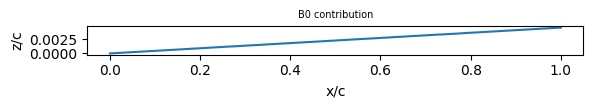

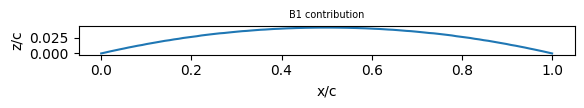

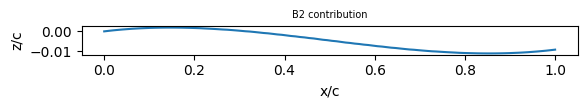

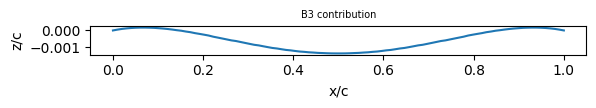

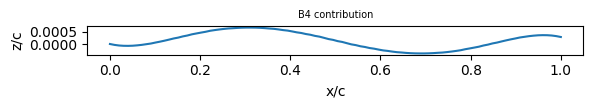

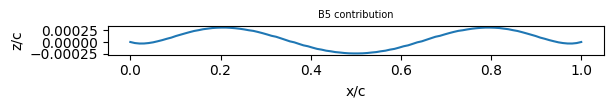

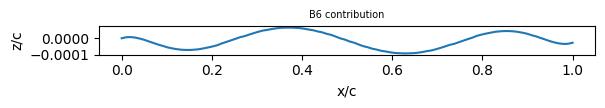

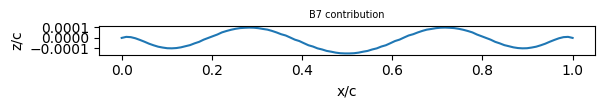

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


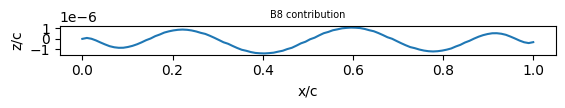

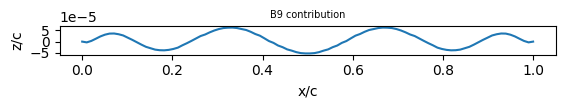

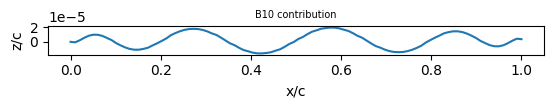

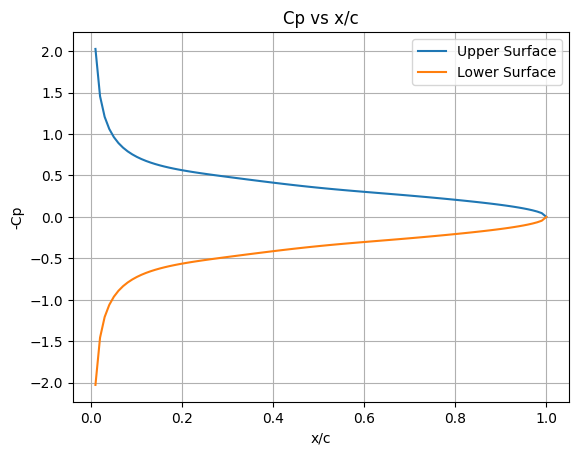

In [ ]:
###For uploading Literature Data excel sheet
from google.colab import files

uploaded = files.upload()

Saving Literature Data.xlsx to Literature Data.xlsx


Drive link to run the code: https://colab.research.google.com/drive/11zPF9-0_5G6SHBtaGKv5oEk29T-yeGSB?usp=sharing
Drive link to literature data: https://docs.google.com/spreadsheets/d/1U05OKGjz1VTN7e6X0rPF3wLeRrjIYe51/edit?usp=sharing&ouid=116928856144566459970&rtpof=true&sd=true

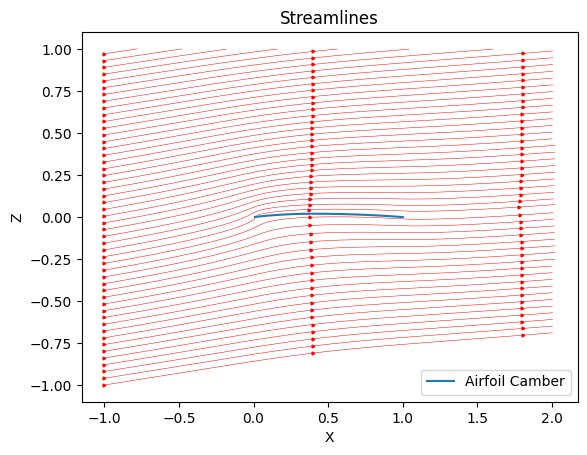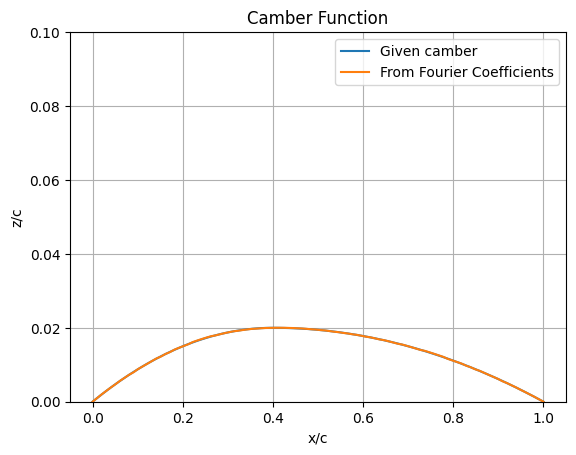